## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [4]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
# Find the given objects points and image points

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
     
def undistort_img(img):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


### Test undistortion

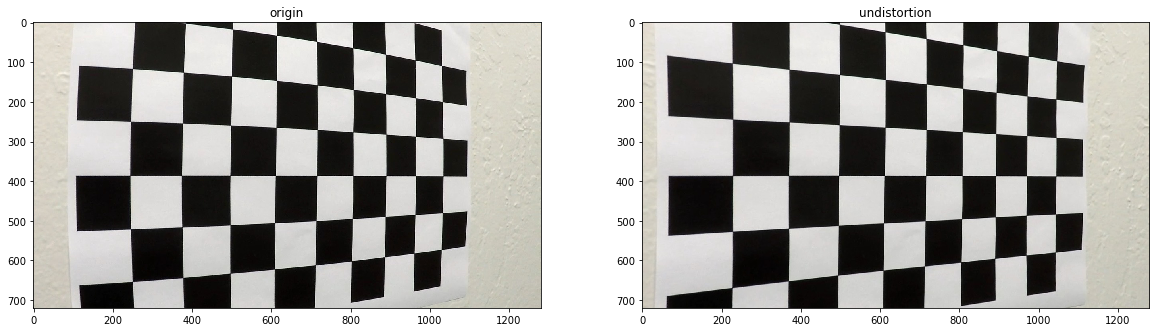

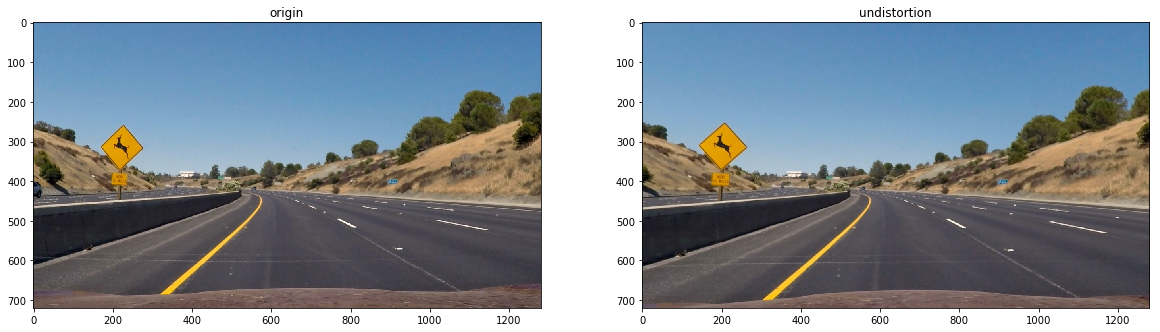

In [6]:

def test_undistort(img):
    dst = undistort_img(img)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title('origin')
    plt.imshow(img)

    plt.subplot(122)
    plt.title('undistortion')
    plt.imshow(dst)
    plt.show()


timg = mpimg.imread('camera_cal/calibration5.jpg')
test_undistort(timg)

timg = mpimg.imread('test_images/test2.jpg')
test_undistort(timg)


## Gradient threshold

In [7]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel =3,thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize = sobel_kernel))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

def dir_thresh(img, sobel_kernel = 3, dir_thresh= (0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    return binary_output


def color_thresh(img,color_thresh=(170,255)):

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    return s_binary


def combined_thresh(img):
    ksize = 9
    
    gradx = abs_sobel_thresh(img, orient='x',sobel_kernel=ksize, thresh=(30,100))
    grady = abs_sobel_thresh(img, orient='y',sobel_kernel=ksize, thresh=(30,100))
    mag_binary = mag_thresh(img,sobel_kernel=ksize, mag_thresh=(50,100))
    dir_binary = dir_thresh(img, sobel_kernel=13, dir_thresh = (0.7, 1.1))
    color_binary = color_thresh(img,color_thresh=(120,255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx==1) & (grady ==1))|((mag_binary == 1) & (dir_binary ==1)) | (color_binary ==1)]=1
    
    return combined


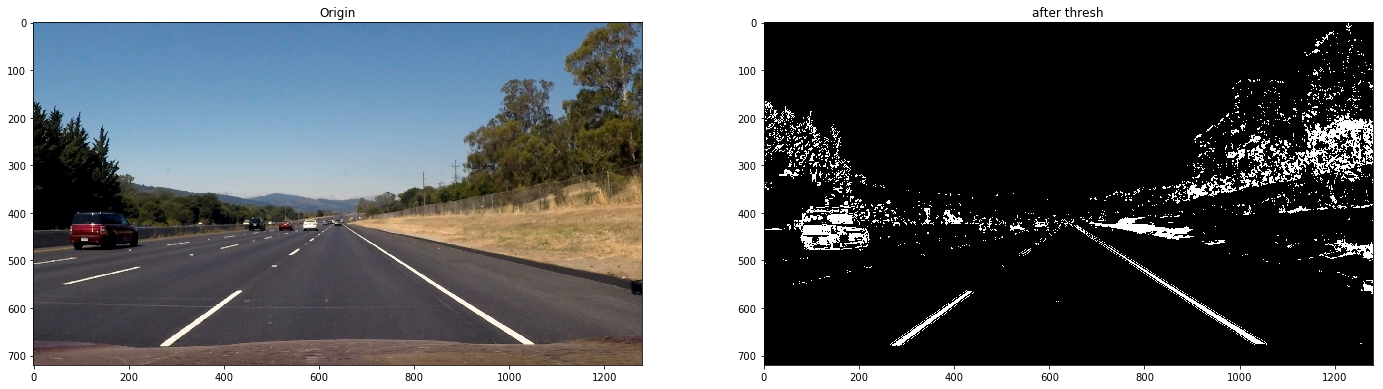

In [8]:
def test_thresh(img):
    comb = combined_thresh(img)

    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.imshow(timg)
    ax1.set_title('Origin')
    ax2.imshow(comb, cmap='gray')
    ax2.set_title('after thresh')
    plt.show()
    

timg = mpimg.imread('test_images/straight_lines2.jpg')
test_thresh(timg)

## Perspective Transform

In [9]:
corner = np.float32([[582,460],[210,720],[1123,720],[700,460]])
offset = 340


def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corner[0],corner[1],corner[2],corner[3]])
    dst = np.float32([[offset,0],[offset,img_size[1]],[img_size[0]-offset,img_size[1]],[img_size[0]-offset,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, Minv  

### Test Perspective

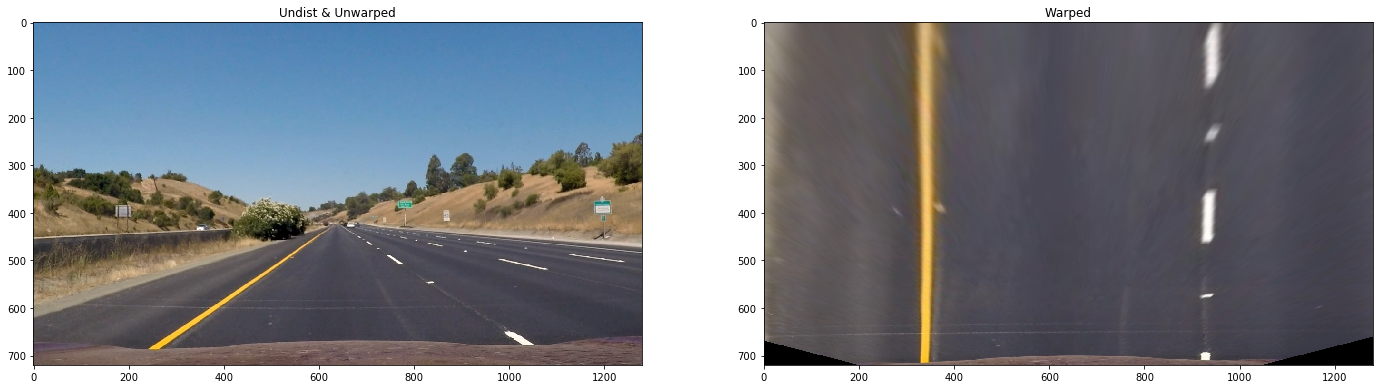

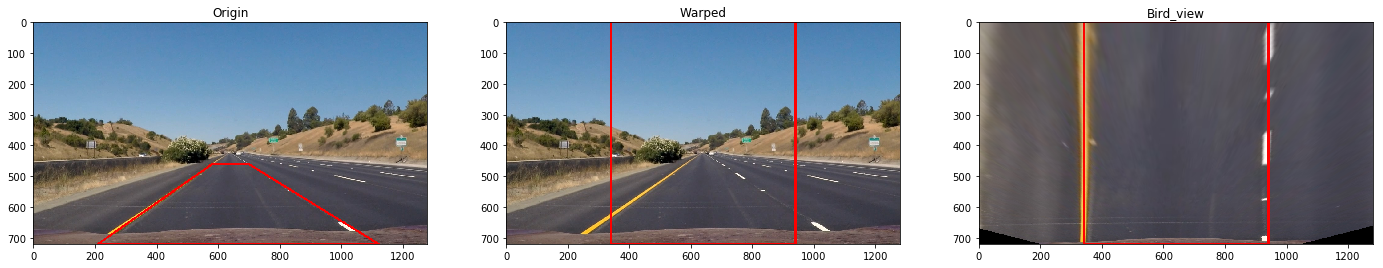

array([[[162, 153, 143],
        [162, 153, 143],
        [163, 154, 144],
        ..., 
        [ 79,  79,  90],
        [ 79,  79,  90],
        [ 80,  79,  90]],

       [[162, 153, 143],
        [162, 153, 143],
        [162, 153, 143],
        ..., 
        [ 79,  79,  90],
        [ 80,  79,  90],
        [ 80,  79,  90]],

       [[161, 153, 142],
        [161, 153, 142],
        [162, 153, 142],
        ..., 
        [ 79,  79,  90],
        [ 80,  79,  90],
        [ 80,  79,  90]],

       ..., 
       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,

In [10]:
# %matplotlib qt4

def test_perspective(img):

    undist= undistort_img(img)
    warped_img, _ = warp_image(undist)
    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.imshow(timg,cmap='gray')
    ax1.set_title('Undist & Unwarped')
    ax2.imshow(warped_img,cmap='gray')
    ax2.set_title('Warped')
    plt.show()


def perspective_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corner[0],corner[1],corner[2],corner[3]])
    dst = np.float32([[offset,0],[offset,img_size[1]],[img_size[0]-offset,img_size[1]],[img_size[0]-offset,0]])
    
    undist= undistort_img(img)
    warped, _ = warp_image(undist)
    
    src_img = img.copy()
    src_pts = src.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(src_img,[src_pts],True,(255,0,0),thickness = 5)
    
    dst_img = img.copy()
    dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(dst_img,[dst_pts],True,(255,0,0),thickness = 5)
    
    warped = warped.copy()
    dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(warped,[dst_pts],True,(255,0,0),thickness = 5)
    

    
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,9))
    ax1.imshow(src_img,cmap='gray')
    ax1.set_title('Origin')
    ax2.imshow(dst_img,cmap='gray')
    ax2.set_title('Warped')
    ax3.imshow(warped,cmap='gray')
    ax3.set_title('Bird_view')
    plt.show()
    
    return warped


timg = mpimg.imread('test_images/straight_lines1.jpg')
test_perspective(timg)
perspective_transform(timg)

## Lind Detections

In [11]:
def lane_lines_detections(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    

    ################################################
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    out_img = np.uint8(out_img)
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx, out_img, leftx, lefty, rightx, righty


### Visualization Line Detections

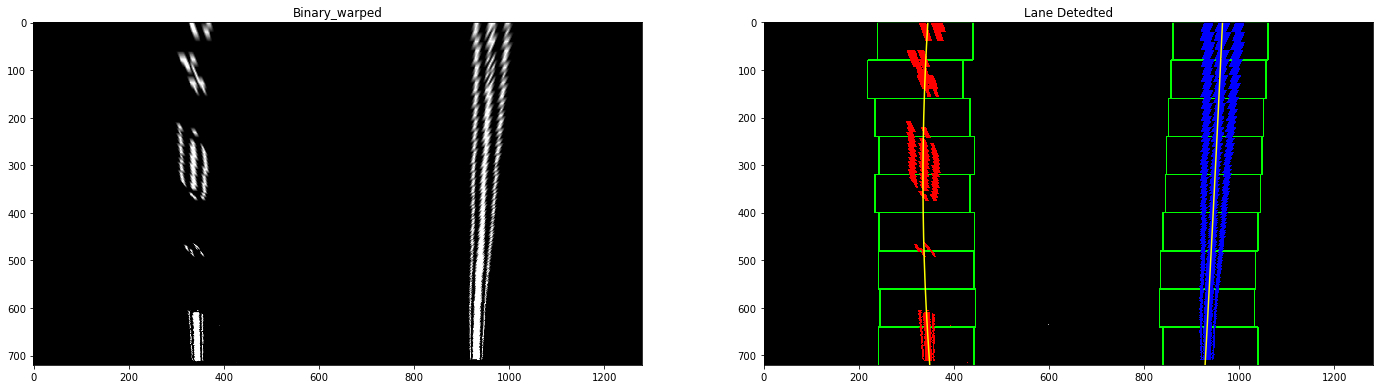

In [12]:
def visual_line_detections(img):
    img = undistort_img(img)
    img = combined_thresh(img)
    binary_warped, _= warp_image(img)
    _, _, ploty, left_fitx, right_fitx, out_img, _, _, _, _ = lane_lines_detections(binary_warped)
    
    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.set_title('Binary_warped')
    ax1.imshow(binary_warped,cmap='gray')
   
    
    ax2.set_title('Lane Detedted')
    ax2.imshow(out_img, cmap='gray')
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

timg = mpimg.imread('test_images/straight_lines2.jpg')
visual_line_detections(timg)

In [20]:
def lane_line_detectation_with_pre_fit(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]   
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    result = np.uint8(result)
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx, result, leftx, lefty, rightx, righty

### Visualization Line Detections with pre fit

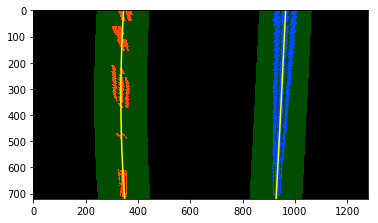

In [21]:
def test_visual_line_detsction_with_pre_fit(img):
    img = undistort_img(img)
    img = combined_thresh(img)
    binary_warped, _= warp_image(img)
    left_fit, right_fit, ploty, left_fitx, right_fitx, out_img, _, _, _, _ = lane_lines_detections(binary_warped)
    left_fit, right_fit, ploty, left_fitx, right_fitx, result,  _, _, _, _ = lane_line_detectation_with_pre_fit(binary_warped, left_fit, right_fit)

    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
timg = mpimg.imread('test_images/straight_lines2.jpg')
test_visual_line_detsction_with_pre_fit(timg)

In [24]:
def cal_lane_curv_and_vehicle_position(ploty, leftx, lefty, rightx, righty, image_size):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature, 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    
    lineLeft = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    lineRight = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    
    distacnce_from_center = (lineRight + lineLeft)/2 - vehicleCenter
    
    return left_curverad,right_curverad, distacnce_from_center

In [25]:
def draw_lines_on_image(warped, undistorted_img, Minv):
    
    ploty, left_fitx, right_fitx, out_img, leftx, lefty, rightx, righty = lane_lines_detections(warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    left_curvature,right_curverad,distance = cal_lane_curv_and_vehicle_position(ploty, leftx, lefty, rightx, righty, 0)
    cv2.putText(result, 'Radius of Curvature: Left = %.2f m, Right = %.2f m' % (left_curvature,right_curverad),  (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    if distance < 0.:
        veh_pos = 'left'
    else:
        veh_pos = 'right'
    
    cv2.putText(result, 'Vehicle is %.2fm %s from center' % (np.absolute(distance), veh_pos),  (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return result
    

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line:
     def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
                
def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        peaks,filtered = find_peaks(img,thresh=3000)
        if len(peaks)!=2:
            print('Trouble ahead! '+ str(len(peaks)) +' lanes detected!')
            plt.imsave('troublesome_image.jpg',img)                        
            
        peak_ind = np.argmin(abs(peaks-window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = lane_from_window(img,window_center,width)
    return lane_binary



In [26]:
def pipeline(img):
    undistorted_img = undistort_img(img)
    thresh = combined_thresh(undistorted_img)
    binary_warped, Minv = warp_image(thresh)
    image_with_lines = draw_lines_on_image(binary_warped, undistorted_img, Minv)
    return image_with_lines

In [ ]:

def process_image(img):
    undistorted_img = undistort_img(img)
    thresh = combined_thresh(undistorted_img)
    binary_warped, Minv = warp_image(thresh)
    
    # if both lane were detected last frame, use lane_line_detectation_with_pre_fit()
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(binary_warped)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = lane_line_detectation_with_pre_fit(binary_warped, l_line.best_fit, r_line.best_fit)
        
    ###### Sanity Check: invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
    
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    return img_out


### Test Pipeline

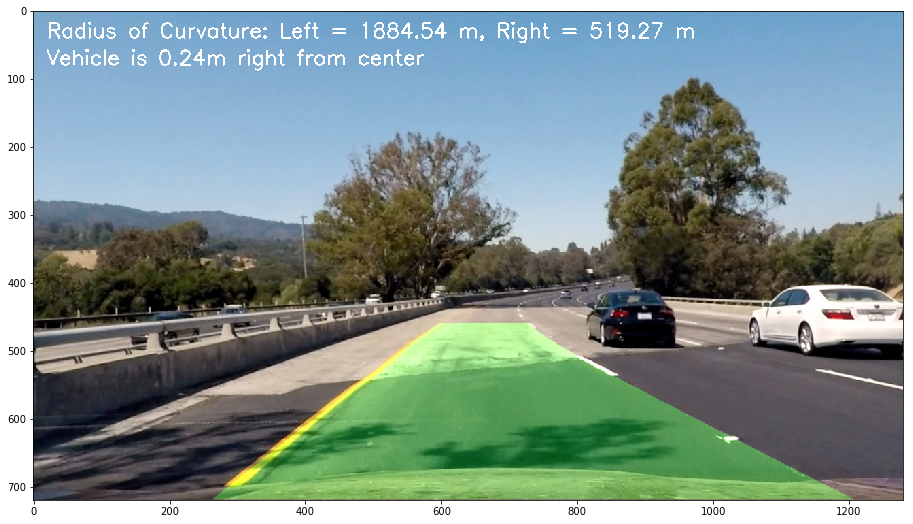

In [27]:
def test_pipeline(img):
    plt.figure(figsize=(24,9))
    processed_img = pipeline(timg)
    plt.imshow(processed_img)
    plt.show()
       
timg = mpimg.imread('test_images/test4.jpg')    
test_pipeline(timg)

### Run on the test Video

In [14]:
video_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [23:28<00:01,  1.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 27min 40s, sys: 2.7 s, total: 27min 42s
Wall time: 23min 29s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))